#### Problem definition

we optimize a mean-deviation risk-averse problem which is given by the following form:

$$\min_{x}{\bm{E}[U(x, \xi)]+\lambda(\bm{E}[\max(0, U(x,\xi)-\bm{E} [U(x,\xi)])^2])^{\tfrac{1}{2}}}$$

This problem is three-level composition optimization as following:

$$f_0(x) = (x, \bm{E}[U(x,\xi)])$$
$$f_1(x, y) = (y, \bm{E}[\max(0, U(x, \xi) - y)])$$
$$f_2(x, y) = x+ \lambda\sqrt{y+\delta}$$

The loss function can be write in the compositional form as:

$$f_2(f_1(f_0(x)))$$

In experiment we define $$U(x,\xi) = (b-g(a^\top x))^2$$  $$g(x)=x^2$$

In [1]:
import sklearn.datasets as skd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, hessian, jacfwd, jacrev
from jax import random

In [2]:
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

gpu


In [3]:
g_func = lambda x: x**2

synthetic_config = {
    'feature_len': 10,  #d
    'num_train_examples': 1000,
    'num_test_examples': 500,  # unused
    'label_noise_rate': 0.1,  # unused
    'g_func': g_func,
}


In [4]:
from scipy.sparse import csr_matrix


def synthetic_dataset(config: dict, sparsity: float = 1.0):
    feature_len = config['feature_len']
    num_train_examples = config['num_train_examples']
    num_test_examples = config['num_test_examples']
    g_func = config['g_func']

    # print(feature_len, num_train_examples)
    # cov_matrix = np.zeros((feature_len, feature_len))
    # for i in range(feature_len):
    #     for j in range(feature_len):
    #         cov_matrix[i, j] = 0.5 * np.exp(-np.abs(i - j) / feature_len)
    cov_matrix = np.random.normal(0, 1, (feature_len, feature_len))
    a = np.random.multivariate_normal(np.zeros(feature_len), cov_matrix,
                                      num_train_examples)
    x_star = np.random.normal(0, 1, (feature_len))
    b = g_func(a @ x_star) + np.random.normal(0, 0.001, (num_train_examples))
    print('b shape: ', b.shape)
    print('Training data generated. shape: ', a.shape, b.shape)
    print('x_star norm: ', np.linalg.norm(x_star))

    test_a = np.random.multivariate_normal(np.zeros(feature_len), cov_matrix,
                                           num_test_examples)
    test_b = g_func(test_a @ x_star)
    print('Test data generated. shape: ', test_a.shape, test_b.shape)

    a = csr_matrix(a)
    test_a = csr_matrix(test_a)
    return (a, b), (test_a, test_b), x_star





In [5]:
def split_dataset(dataset, num_val):
    val_index = np.random.choice(range(dataset[0].shape[0]),
                                 num_val,
                                 replace=False).astype(int)
    mask = np.zeros(dataset[0].shape[0]).astype(bool)
    mask[val_index] = True
    dataset_val = (dataset[0][mask], dataset[1][mask])
    dataset_train = (dataset[0][~mask], dataset[1][~mask])
    return dataset_train, dataset_val


def client_split(dataset, num_clients):
    split_num_example = dataset[0].shape[0] // num_clients
    ret = []
    for _ in range(num_clients):
        dataset, split = split_dataset(dataset, split_num_example)
        ret.append(split)
    return ret


def sample_batch(A, b, batch_size):
    num_examples = b.shape[0]
    index = np.random.choice(num_examples, batch_size, replace=False)
    A_batch = A[index]
    b_batch = b[index]
    return A_batch, b_batch, index

In [6]:
def func_g(x):
    return jnp.square(x)


def func_U(x, a, b, func_g=func_g):
    return jnp.square((b - func_g(a @ x)))


def func_f2(x, y, lmbda, delta):
    return x + lmbda * jnp.sqrt(y + delta)


def func_f1(x, y, a, b, func_U=func_U):
    t1 = jnp.maximum(0, func_U(x, a, b) - y)
    t1 = jnp.square(t1)
    mean_t1 = jnp.mean(t1)
    return y, mean_t1


def func_f0(x, a, b):
    t1 = func_U(x, a, b)
    mean_t1 = jnp.mean(t1)
    return x, mean_t1


def func_loss(x, a, b, lmbda, delta):
    y3, y4 = func_f0(x, a, b)
    y1, y2 = func_f1(y3, y4, a, b)
    return func_f2(y1, y2, lmbda, delta)


def compute_grad_MCA(x, a, b, lmbda, delta):
    y3, y4 = func_f0(x, a, b)
    y1, y2 = func_f1(y3, y4, a, b)

    g0 = jacfwd(func_f0, 0)(x, a, b)
    g1 = jacfwd(func_f1, (0, 1))(y3, y4, a, b)
    g2 = jacfwd(func_f2, (0, 1))(y1, y2, lmbda, delta)
    g121 = g0[0] @ jnp.expand_dims(g1[0][0], axis=1) + jnp.expand_dims(
        g0[1] * g1[0][1], axis=1)
    g122 = g0[0] @ jnp.expand_dims(g1[1][0], axis=1) + jnp.expand_dims(
        g0[1] * g1[1][1], axis=1)
    g = jnp.reshape(g121 * g2[0] + g122 * g2[1], -1)
    return g


In [7]:
synthetic_train, synthetic_test, x_star = synthetic_dataset(synthetic_config)
need_bias = False
train_data = synthetic_train
test_data = synthetic_test
num_clients = 2
if need_bias:
    bias = np.ones((train_data[0].shape[0], 1))
    train_data = (np.concatenate((train_data[0].toarray(), bias),
                                 axis=1), train_data[1])
    bias = np.ones((test_data[0].shape[0], 1))
    test_data = (np.concatenate((test_data[0].toarray(), bias),
                                axis=1), test_data[1])
else:
    train_data = (train_data[0].toarray(), train_data[1])
    test_data = (test_data[0].toarray(), test_data[1])
train_data = jnp.asarray(train_data[0]), jnp.asarray(train_data[1])
test_data = jnp.asarray(test_data[0]), jnp.asarray(test_data[1])

splits_data = client_split(train_data, num_clients)


/tmp/ipykernel_71165/1034211505.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  a = np.random.multivariate_normal(np.zeros(feature_len), cov_matrix,
/tmp/ipykernel_71165/1034211505.py:24: RuntimeWarning: covariance is not positive-semidefinite.
  test_a = np.random.multivariate_normal(np.zeros(feature_len), cov_matrix,


b shape:  (1000,)
Training data generated. shape:  (1000, 10) (1000,)
x_star norm:  2.7632040212353726
Test data generated. shape:  (500, 10) (500,)


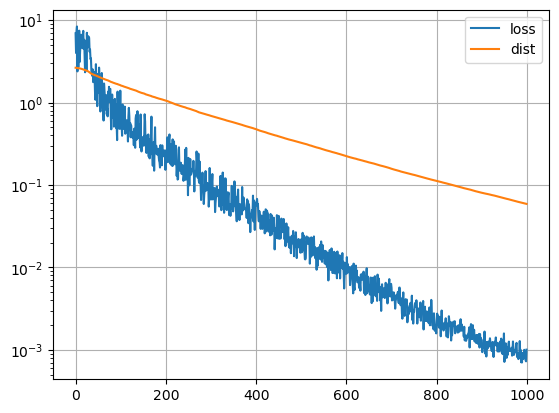

In [8]:
import numpy.linalg as npl

lmbda = 0.1
delta = 0.1
x = jnp.ones((train_data[0].shape[1])) * 0.1
eta = 0.01
num_iter = 1000
loss_nonfed = np.zeros(num_iter)
dist_nonfed = np.zeros(num_iter)
grad_diff = np.zeros(num_iter)
for iter in range(num_iter):
    # compute direct loss
    a, b, index = sample_batch(train_data[0], train_data[1], 100)
    loss, loss_grad = value_and_grad(func_loss, 0)(x, a, b, lmbda, delta)

    loss = loss / a.shape[0]
    loss_grad = loss_grad / a.shape[0]
    loss_nonfed[iter] = loss
    dist_nonfed[iter] = jnp.linalg.norm(x - x_star)

    x -= eta * loss_grad
plt.cla()
plt.grid('--')
plt.plot(loss_nonfed, label='loss')
plt.plot(dist_nonfed, label='dist')
plt.legend()
plt.yscale('log')
plt.show()

In [9]:
def s_func(Z, a, b, lmbda, delta):
    S = []
    
    s0 = [jnp.zeros(Z[0][0].shape)]
    S.append(s0)
    f0 = func_f0(Z[0][0], a, b)
    s1 = [Z[1][0] - f0[0], Z[1][1] - f0[1]]
    S.append(s1)
    f1 = func_f1(Z[1][0], Z[1][1], a, b)
    s2 = [Z[2][0] - f1[0], Z[2][1] - f1[1]]
    S.append(s2)
    f2 = func_f2(Z[2][0], Z[2][1], lmbda, delta)
    s3 = [Z[3][0] - f2]
    S.append(s3)
    return S

def p_func(Z, a, b, lmbda, delta):
    P = []
    g0 = jacfwd(func_f0, 0)(Z[0][0], a, b)
    g1 = jacfwd(func_f1, (0, 1))(Z[1][0], Z[1][1], a, b)
    g2 = jacfwd(func_f2, (0, 1))(Z[2][0], Z[2][1], lmbda, delta)
    g121 = g0[0] @ jnp.expand_dims(g1[0][0], axis=1) + jnp.expand_dims(
        g0[1] * g1[0][1], axis=1)
    g122 = g0[0] @ jnp.expand_dims(g1[1][0], axis=1) + jnp.expand_dims(
        g0[1] * g1[1][1], axis=1)
    g = jnp.reshape(g121 * g2[0] + g122 * g2[1], -1)
    return [g]


In [10]:
def get_init_z(x, a, b, lmbda, delta):
    y3, y4 = func_f0(x, a, b)
    y1, y2 = func_f1(y3, y4, a, b)
    y = func_f2(y1, y2, lmbda, delta)
    z = [[x], [y3, y4], [y1, y2], [y]]
    return z

def list_sum(l):
    num_element = len(l)
    sum = []
    for i in range(len(l[0])):
        sum.append([])
        for j in range(len(l[0][i])):
            sum[i].append([])
            for n in range(num_element):
                sum[i][j].append(l[n][i][j])
    for i in range(len(sum)):
        for j in range(len(sum[i])):
            sum[i][j] = jnp.array(sum[i][j])
            sum[i][j] = jnp.sum(sum[i][j], axis=0)
    return sum


def list_avg(l):
    num_element = float(len(l))
    sum = list_sum(l)
    #print(sum)
    for i in range(len(sum)):
        for j in range(len(sum[i])):
            sum[i][j] = sum[i][j] / num_element
    return sum


def list_mul(a, l):
    result = []
    for i in range(len(l)):
        result.append([])
        for j in range(len(l[i])):
            result[i].append([])
            result[i][j] = l[i][j] * a
    return result

x-x_star 2.635001
x-x_star 2.5436094
x-x_star 2.4462707
x-x_star 2.2950423
x-x_star 2.1205945
x-x_star 1.9766989
x-x_star 1.8684325
x-x_star 1.769014
x-x_star 1.6625199
x-x_star 1.5547624
x-x_star 1.4556427
x-x_star 1.3710829
x-x_star 1.304526
x-x_star 1.2491404
x-x_star 1.1953092
x-x_star 1.1285083
x-x_star 1.0719249
x-x_star 1.0099552
x-x_star 0.95707124
x-x_star 0.9087939
x-x_star 0.87036234
x-x_star 0.8331818
x-x_star 0.7917304
x-x_star 0.7494796
x-x_star 0.71170837
x-x_star 0.6776051
x-x_star 0.64954054
x-x_star 0.6199641
x-x_star 0.5942866
x-x_star 0.5727468
x-x_star 0.5469836
x-x_star 0.5205128
x-x_star 0.4942302
x-x_star 0.47226974
x-x_star 0.45085946
x-x_star 0.43168226
x-x_star 0.41246584
x-x_star 0.39416677
x-x_star 0.37635207
x-x_star 0.3599165
x-x_star 0.34468848
x-x_star 0.33040288
x-x_star 0.3129471
x-x_star 0.29787493
x-x_star 0.28280884
x-x_star 0.2716559
x-x_star 0.2614278
x-x_star 0.25047442
x-x_star 0.23879148
x-x_star 0.22732882
x-x_star 0.21684286
x-x_star 0.20690

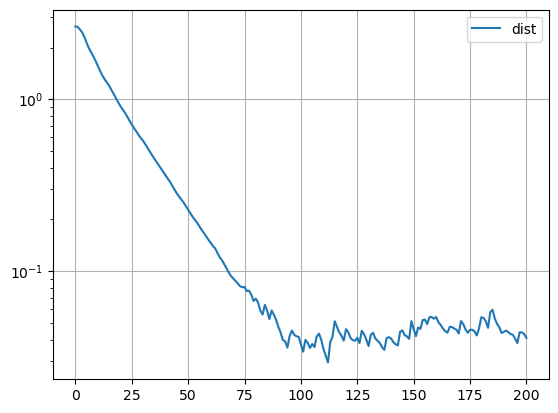

In [13]:
num_selected_clients = 1
num_round = 200
rho = 0.5
lmbda = 0.1
delta = 0.1
inner_epoch = 5
beta = 0.0003
alpha = 0.0003
batch_size = 100

x = jnp.ones((train_data[0].shape[1]), dtype=jnp.float32)*0.1  

fedMSA_loss = []
fedMSA_dist = [jnp.linalg.norm(x - x_star)]

# initialize z0 and z-1
selected_clients = list(range(num_clients))
z_client_list = []
q_client_list = []
h_client_list = []
for client in selected_clients:
    a, b, index = sample_batch(splits_data[client][0], splits_data[client][1],
                               100 // num_selected_clients)
    z_client = get_init_z(x, a, b, lmbda, delta)
    z_client_list.append(z_client)
z = list_avg(z_client_list)

z_glob_list = [z, z]
q_glob_list = []
h_glob_list = []




# start MSA
for round in range(num_round):
    # Global update h_glob and q_glob

    selected_clients = list(range(num_clients))
    h_client_list = []
    q_client_list = []

    if round == 0:
        rho_cur = 1
        inner_epoch_cur = 1
    else:
        rho_cur = rho
        inner_epoch_cur = inner_epoch
        
    
    alpha_cur = alpha*(0.999**round)
    beta_cur = beta*(0.90**round)
    batch_size_cur = int(min(499, batch_size*(1.00**round)))
    for client in selected_clients:
        a, b, index = sample_batch(splits_data[client][0],
                                   splits_data[client][1],
                                   batch_size_cur // num_selected_clients)
        z_cur = z_glob_list[-1]
        # z_cur[0][0] = x
        h_client = p_func(z_cur, a, b, lmbda, delta)
        q_client = s_func(z_cur, a, b, lmbda, delta)
        if rho_cur < 1:
            z_last = z_glob_list[-2]
            # z_last[0][0] = x
            p_last = p_func(z_last, a, b, lmbda, delta)
            s_last = s_func(z_last, a, b, lmbda, delta)
            h_client = list_sum([h_client, list_mul(1-rho_cur, h_glob_list[-1]), list_mul(rho_cur-1, p_last)])
            q_client = list_sum([q_client, list_mul(1-rho_cur, q_glob_list[-1]), list_mul(rho_cur-1, s_last)])
        h_client_list.append(h_client)
        q_client_list.append(q_client)
    h_glob = list_avg(h_client_list)
    q_glob = list_avg(q_client_list)
    h_glob_list.append(h_glob)
    q_glob_list.append(q_glob)
    if len(h_glob_list)>1:
        h_glob_list.pop(0)
        q_glob_list.pop(0)
    if len(z_glob_list)>2:
        z_glob_list.pop(0)


    # Local SGD with momentum-type variance reduction
    selected_clients = np.random.choice(range(num_clients),
                                    num_selected_clients,
                                    replace=False)
    
    x_client_list = []
    z_client_list = []
    for client in selected_clients:
        h_client = h_glob_list[-1].copy()
        q_client = q_glob_list[-1].copy()
        x_cur, x_last = x.copy(), x.copy() 
        z_cur, z_last = z_glob_list[-1].copy(), z_glob_list[-1].copy()
        a, b, index = sample_batch(splits_data[client][0],
                                   splits_data[client][1],
                                   batch_size_cur // num_selected_clients)
        for epoch in range(inner_epoch_cur):
            
            p_cur = p_func(z_cur, a, b, lmbda, delta)
            p_last = p_func(z_last, a, b, lmbda, delta)
            s_cur = s_func(z_cur, a, b, lmbda, delta)
            s_last = s_func(z_last, a, b, lmbda, delta)
            h_client = list_sum([p_cur, h_client, list_mul(-1., p_last)])
            q_client = list_sum([s_cur, q_client, list_mul(-1., s_last)])
            x_last, z_last = x_cur.copy(), z_cur.copy()
            x_cur = x_cur - alpha_cur * jnp.array(h_client[0])

            z_cur = list_sum([z_cur, list_mul(-beta_cur, q_client)])
            z_cur[0][0] = x_cur
        x_client_list.append(x_cur)
        
        z_client_list.append(z_cur)
        
        z_cur[0][0] = x_cur
    x = jnp.mean(jnp.array(x_client_list), axis=0)
    z = list_avg(z_client_list)
    z[0][0] = x
    z_glob_list.append(z)
    print('x-x_star', jnp.linalg.norm(x - x_star))
    fedMSA_dist.append(jnp.linalg.norm(x - x_star))

plt.cla()

plt.plot(fedMSA_dist, label='dist')
plt.legend()
plt.grid('--')
plt.yscale('log')
plt.show()

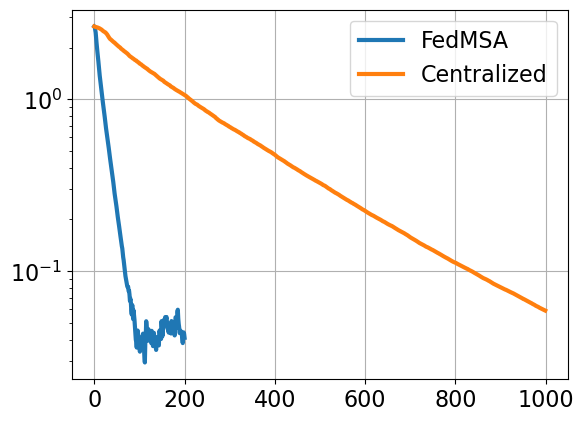

In [15]:
plt.cla()
plt.plot(fedMSA_dist, label='FedMSA',linewidth=3)
# plt.plot(np.arange(len(fedMSA_dist)) * 10, fedMSA_dist, label='Ours adjusted')
plt.plot(dist_nonfed, label='Centralized',linewidth=3)
#plt.plot(fedAvg_dist, label='FedAvg')
# plt.plot(np.arange(len(fedAvg_dist)) * 10,
#          fedAvg_dist,
#          label='FedAvg adjusted')
plt.grid('--')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.savefig('fedMCO.pdf')
plt.show()